In [ ]:
import numpy as np
import pandas as pd


# modelling
from sklearn.model_selection import train_test_split


# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2
from google.colab import drive
drive.mount('/content/drive')
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score,roc_auc_score

import pickle
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import normalize
from imblearn.over_sampling import SMOTENC



Mounted at /content/drive


In [ ]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 5.2 MB/s 


In [ ]:
import shap

# EDA

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/telecom_users.csv')

In [ ]:
df=df.drop(columns=['Unnamed: 0','customerID'])

In [ ]:
df['TotalCharges']=df['TotalCharges'].replace(" ",np.nan, regex=True)
df['TotalCharges']=df['TotalCharges'].astype('float64')
df=df[df['TotalCharges'].isna()==False]
df['TotalCharges'].isna().sum()

0

In [ ]:
df.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [ ]:
df=df.drop(columns=['TotalCharges'])


In [ ]:
df['SeniorCitizen']=df['SeniorCitizen'].apply(lambda x: 'Yes' if x==1 else 'No')

In [ ]:
df['Churn']=df['Churn'].apply(lambda x: 1 if x=='Yes' else 0)

In [ ]:
df.Churn.value_counts()

0    4389
1    1587
Name: Churn, dtype: int64

In [ ]:
categorical_features = df.select_dtypes(include=['object']).columns.tolist()
numeric_features = df.select_dtypes(exclude=['object']).columns.tolist()


# Test split and SMOTENC

In [ ]:
X = df.iloc[:,:-1]
y = df['Churn']

In [ ]:
y.value_counts()

0    4389
1    1587
Name: Churn, dtype: int64

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
y_train.value_counts()

0    3511
1    1269
Name: Churn, dtype: int64

In [ ]:
from imblearn.over_sampling import SMOTENC

smotenc = SMOTENC([df.columns.get_loc(c) for c in categorical_features],random_state=42)
X_train_smote, y_train_smote = smotenc.fit_resample(X_train, y_train)

In [ ]:
X_train_smote.shape, y_train_smote.shape

((7022, 18), (7022,))

# Data encoding and transformations

In [ ]:
X_train_cat = X_train_smote.select_dtypes(include='object')
X_train_num = X_train_smote.select_dtypes(exclude='object')
cat_cols = X_train_cat.columns
cat_dummy_encoder = OneHotEncoder(handle_unknown='ignore')
X_train_cat_ohe = cat_dummy_encoder.fit_transform(X_train_cat)
X_train_cat_ohe.toarray()
cat_dummy_encoder.get_feature_names_out(cat_cols)
cat_dummy_encoder = OneHotEncoder(handle_unknown='ignore', )
X_train_cat_ohe = cat_dummy_encoder.fit_transform(X_train_cat).toarray()
cat_ohe_cols = cat_dummy_encoder.get_feature_names_out(cat_cols)
X_train_cat_ohe = pd.DataFrame(X_train_cat_ohe, 
                               columns=cat_ohe_cols)

In [ ]:
num_cols = X_train_num.columns
ss = StandardScaler()
X_train_num_scaled = ss.fit_transform(X_train_num)
X_train_num_scaled = pd.DataFrame(X_train_num_scaled, 
                                  columns=num_cols)

In [ ]:
X_train = pd.concat([X_train_num_scaled, X_train_cat_ohe], axis=1)
final_columns = X_train.columns.tolist()
# just to maintain a proper column order
X_train = X_train[final_columns]


In [ ]:
# separate into cat and num features
X_test_cat = X_test[cat_cols]
X_test_num = X_test[num_cols]


# one hot encoding to encode categorical features
X_test_cat_ohe = cat_dummy_encoder.transform(X_test_cat).toarray()
X_test_cat_ohe = pd.DataFrame(X_test_cat_ohe, 
                               columns=cat_ohe_cols)


# standard scale num features
X_test_num_scaled = ss.transform(X_test_num)
X_test_num_scaled = pd.DataFrame(X_test_num_scaled, 
                                  columns=num_cols)

X_test = pd.concat([X_test_num_scaled, X_test_cat_ohe], axis=1)
X_test = X_test[final_columns]


# Logistical Model

In [ ]:
lr_model = LogisticRegression(random_state=42, solver='liblinear')

In [ ]:
lr_model.fit(X_train,y_train_smote)

LogisticRegression(random_state=42, solver='liblinear')

In [ ]:
predict=lr_model.predict(X_test)

In [ ]:
print(classification_report(y_test,predict))

              precision    recall  f1-score   support

           0       0.89      0.76      0.82       878
           1       0.53      0.73      0.61       318

    accuracy                           0.75      1196
   macro avg       0.71      0.75      0.72      1196
weighted avg       0.79      0.75      0.76      1196



# Explainable AI with SHAP

In [ ]:
import shap

In [ ]:
explainer=shap.KernelExplainer(lr_model.predict,shap.sample(X_train,1000))

X does not have valid feature names, but LogisticRegression was fitted with feature names


In [ ]:
shap_values = explainer.shap_values(X_test)

In [ ]:
shap.summary_plot(shap_values, X_test, plot_type='bar')

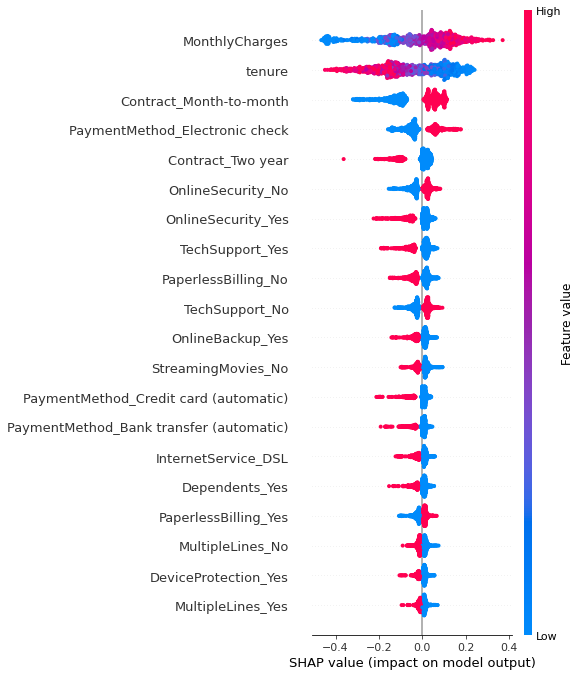

In [ ]:
shap.summary_plot(shap_values, X_test)

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[13, :], X_test.iloc[13, :])

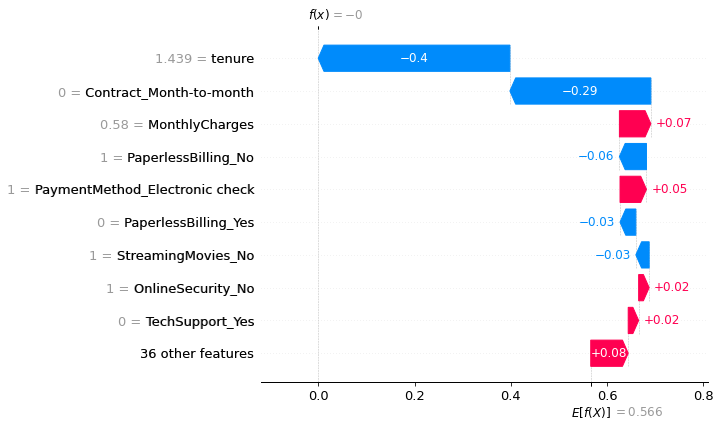

In [ ]:
shap.plots._waterfall.waterfall_legacy(explainer.expected_value, shap_values[13],X_test.iloc[13, :])

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[10, :], X_test.iloc[10, :])

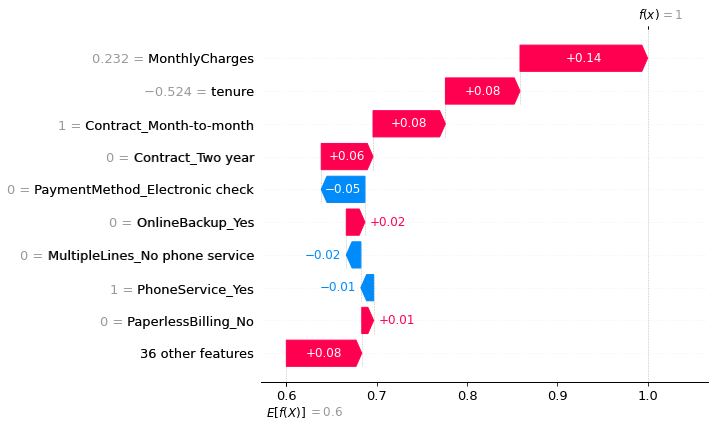

In [ ]:
shap.plots._waterfall.waterfall_legacy(explainer.expected_value, shap_values[10],X_test.iloc[10, :])

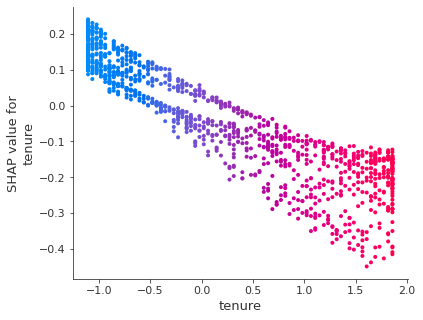

In [ ]:
shap.dependence_plot(ind='tenure', interaction_index='tenure',
                     shap_values=shap_values, 
                     features=X_test,  
                     display_features=X_test)

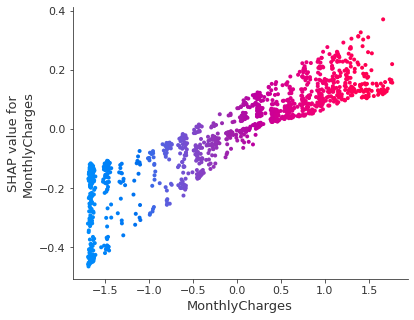

In [ ]:
shap.dependence_plot(ind='MonthlyCharges', interaction_index='MonthlyCharges',
                     shap_values=shap_values, 
                     features=X_test,  
                     display_features=X_test)

# To further check data transformations with DataFrameMapper

In [ ]:
from imblearn.over_sampling._smote.base import OrdinalEncoder
from sklearn_pandas import DataFrameMapper

cat=[([c], [OneHotEncoder()]) for c in categorical_features]
num=[([n], StandardScaler()) for n in numeric_features[:-1]]
mapper=DataFrameMapper(num+cat,df_out=True)
reg=LogisticRegression()
pipeline=Pipeline([('preprocess',mapper), ('reg',reg)])

In [ ]:
from imblearn.over_sampling import SMOTENC

smotenc = SMOTENC([df.columns.get_loc(c) for c in categorical_features],random_state=42)
X_train_smote, y_train_smote = smotenc.fit_resample(X_train, y_train)